## 1. Dataset Description

* There are 2 datasets, taken from: https://www.kaggle.com/CooperUnion/anime-recommendations-database?select=anime.csv

Anime

* anime_id - myanimelist.net's unique id identifying an anime.  
* name - full name of anime.  
* genre - comma separated list of genres for this anime.  
* type - movie, TV, OVA, etc.  
* episodes - how many episodes in this show. (1 if movie).  
* rating - average rating out of 10 for this anime.  
* members - number of community members that are in this anime's "group".  


Rating.csv

* user_id - non identifiable randomly generated user id.  
* anime_id - the anime that this user has rated.  
* rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
---

In [30]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [1]:
anime = pd.read_csv("data/anime.csv")
rating = pd.read_csv("data/rating.csv")

## 2. Genre Analysis
----

In [56]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic,...",TV,64,9.26,793665
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samur...",TV,51,9.25,114262
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",TV,24,9.17,673572
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samur...",TV,51,9.16,151266


In [7]:
# First, we have to explode the dataframe such that each row is a unique anime and genre pair
anime['genre'] = anime['genre'].str.split(',')

In [9]:
anime_genres = anime.explode('genre')

In [10]:
anime_genres.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,Drama,Movie,1,9.37,200630
0,32281,Kimi no Na wa.,Romance,Movie,1,9.37,200630
0,32281,Kimi no Na wa.,School,Movie,1,9.37,200630
0,32281,Kimi no Na wa.,Supernatural,Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,Action,TV,64,9.26,793665


In [72]:
## There are some genres that are NaN. These seem like they are mostly movies or special episodes.
## Let's drop these from our analyses for now

anime_genres = anime_genres.dropna()
anime_genres['genre'] = anime_genres['genre'].str.strip()

We can look at correlations between average number of community members in each genre, average number of anime in each genre, average ratings in each genre and average number of episodes in each genre

In [79]:
anime_genres_eps.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object

<ipython-input-85-93f3d45ecfb4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_genres_eps['episodes'] = anime_genres_eps['episodes'].astype('int')


[Text(0.5, 0, 'Average no. of members'),
 Text(1.5, 0, 'No. of animes produced'),
 Text(2.5, 0, 'Average no. of anime episodes'),
 Text(3.5, 0, 'Average rating per anime')]

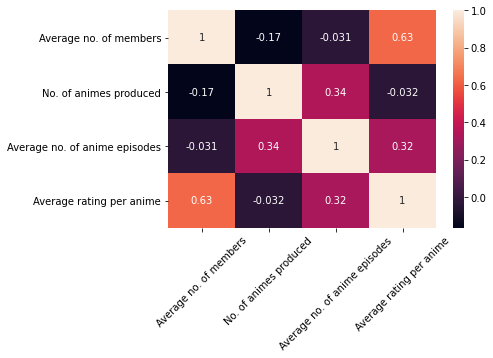

In [85]:
anime_genres_eps = anime_genres[anime_genres['episodes'] != 'Unknown']
anime_genres_eps['episodes'] = anime_genres_eps['episodes'].astype('int')

anime_genres_agg = anime_genres_eps.groupby('genre').agg({"members": "mean",
                                                         "anime_id": "count",
                                                         "episodes": "mean",
                                                         "rating": "mean"}).reset_index()

anime_genres_agg.rename(columns={"members": "Average no. of members",
                                 "anime_id": "No. of animes produced",
                                 "episodes": "Average no. of anime episodes",
                                 "rating": "Average rating per anime"}, 
                        inplace=True)

chart = sns.heatmap(anime_genres_agg[['Average no. of members', 'No. of animes produced',
                             "Average no. of anime episodes", 
                             "Average rating per anime"]].corr(), annot=True)

chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

Average rating per anime highly correlates with average number of community members in each genre

We can look at a word cloud to see which genres has the most number of animes produced

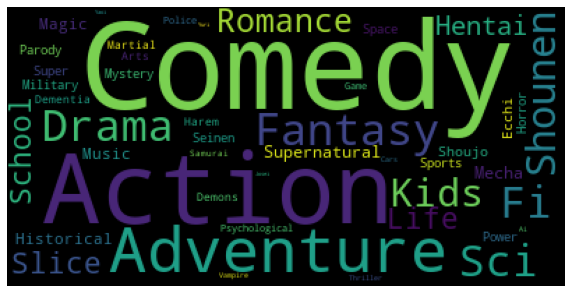

In [73]:
genres = " ".join(gen for gen in list(anime_genres.genre))
wordcloud = WordCloud(collocations=False).generate(genres)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Looks like Action, Comedy and Adventure animes have the most number of animes produced

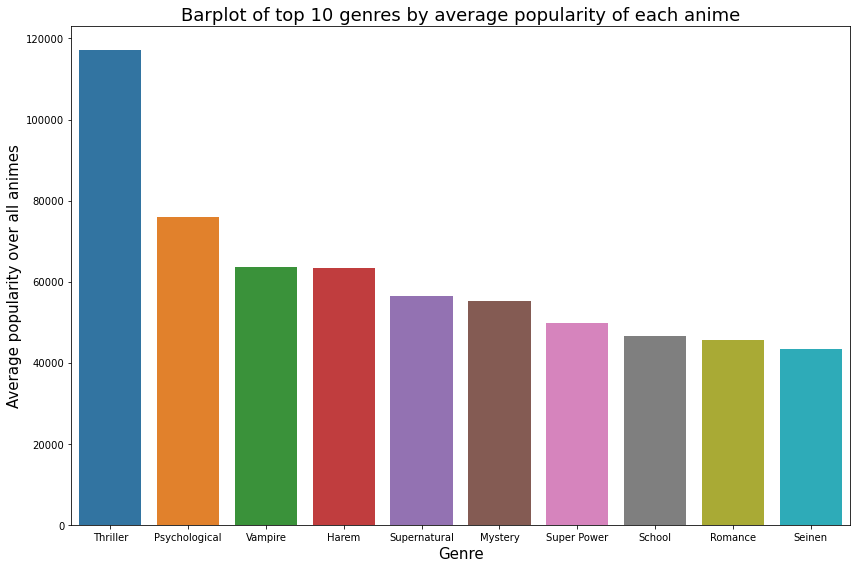

In [74]:
avg_pop_genre = anime_genres.groupby('genre').agg({"members": "mean"}).reset_index().sort_values(by='members', ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
# make barplot and sort bars in descending order
sns.barplot(x='genre', 
            y="members", 
            data=avg_pop_genre, 
            order=avg_pop_genre.sort_values('members',ascending = False).genre.iloc[:10],
            ax=ax)
# set labels
ax.set_xlabel("Genre", size=15)
ax.set_ylabel("Average popularity over all animes", size=15)
ax.set_title("Barplot of top 10 genres by average popularity of each anime", size=18)
plt.tight_layout()

This is pretty interesting! The average size of community members is higher for genres like thriller, psychological, Josei and Harem, even though animes from these genres are not the most commonly produced. These indicates a specialized fan base for these animes whereas genres that are have the most animes produced tend to appeal to the masses

<AxesSubplot:xlabel='genre', ylabel='members'>

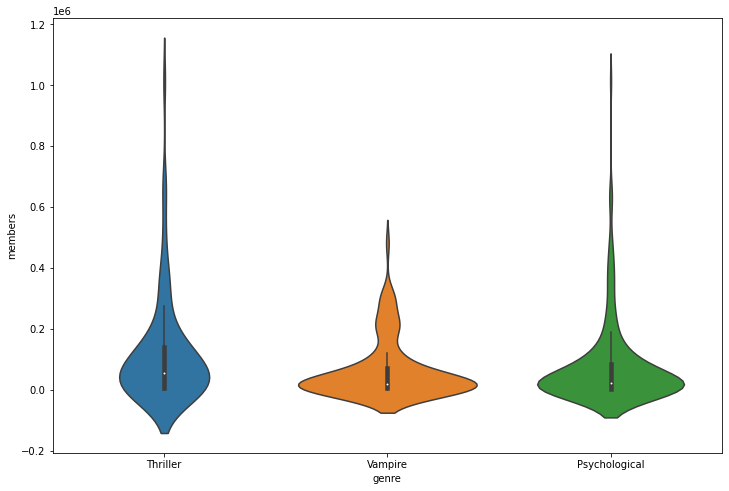

In [96]:
top_3_genres_by_members = list(avg_pop_genre.sort_values('members',ascending = False).genre[:3])
fig, ax = plt.subplots(figsize=(12, 8))
sns.violinplot(x="genre", y="members", data=anime_genres[anime_genres['genre'].isin(top_3_genres_by_members)],
              ax=ax)

We see that in general, thrillers have the largest community on average for each anime, as seen from the highest median as compared to the other two genre. Vampire genre animes tend to be shorter tailed, hence animes in this genre tend to have a similar number of community members. Thriller and psychological animes have longer tails, signifying a larger variety of animes in each of these genres

<ipython-input-75-7dde8fe5cf90>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_genres_eps['episodes'] = anime_genres_eps['episodes'].astype('int')


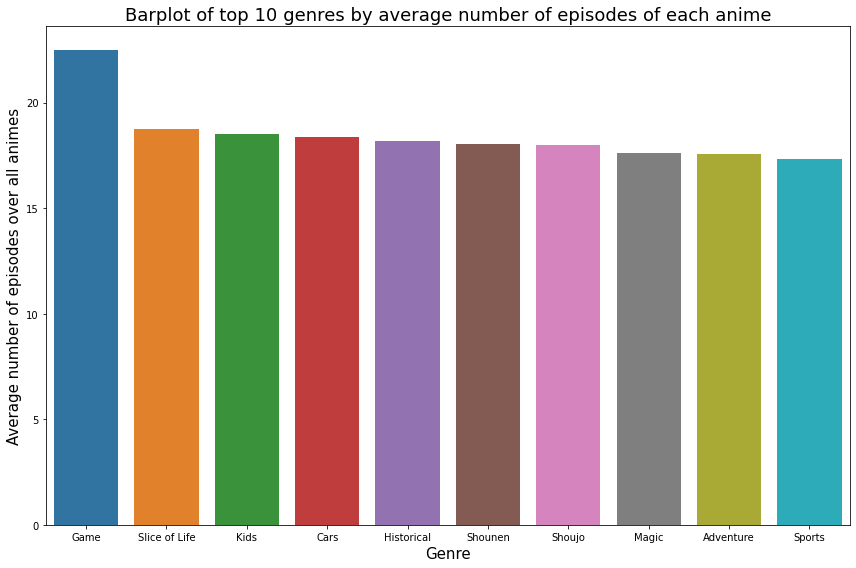

In [75]:
anime_genres_eps = anime_genres[anime_genres['episodes'] != 'Unknown']

anime_genres_eps['episodes'] = anime_genres_eps['episodes'].astype('int')
avg_eps_genre = anime_genres_eps.groupby('genre').agg({"episodes": "mean"}).reset_index().sort_values(by='episodes', ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
# make barplot and sort bars in descending order
sns.barplot(x='genre', 
            y="episodes", 
            data=avg_eps_genre, 
            order=avg_eps_genre.sort_values('episodes',ascending = False).genre.iloc[:10],
            ax=ax)
# set labels
ax.set_xlabel("Genre", size=15)
ax.set_ylabel("Average number of episodes over all animes", size=15)
ax.set_title("Barplot of top 10 genres by average number of episodes of each anime", size=18)
plt.tight_layout()

Game animes, on average runs the longest followed by Slice of Life and Kids

To measure top genres based on quality of animes, we can use user ratings as a proxy